# Imports

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
# Read data
df = pd.read_csv('/kaggle/input/ibm-classification-feature-engineering/all_data.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

In [3]:
df.head(5)

Symbol  Adj Close       Close        High         Low        Open  \
0     179  79.109352  117.541809  118.311035  117.508362  117.834450   
1      26  46.221848   72.696129   72.878838   72.216515   72.581932   
2     412  31.606541   36.820000   36.992001   36.007999   36.467999   
3     135  70.018379   95.585785   96.812103   95.346275   95.997757   
4     219  75.137581  103.604988  104.036430  102.876320  103.614571   

      Volume   S&P500  Unemployment Rate (%)  Consumer Confidence Index  ...  \
0  2295244.0  1936.92                    6.1                       92.4  ...   
1  1603582.0  1936.92                    6.1                       92.4  ...   
2  1169750.0  1936.92                    6.1                       92.4  ...   
3  2579793.0  1936.92                    6.1                       92.4  ...   
4  1431100.0  1936.92                    6.1                       92.4  ...   

       MACD  MACD Signal Line  MACD Histogram    MACD-V  MACD-V Signal Line  \
0 -0.638684         -0.430424       -0.208259 -1.606591           -1.081145   
1 -0.195987         -0.138043       -0.057944 -0.722557           -0.509002   
2 -0.254930         -0.362488        0.107558 -4.684555           -6.641059   
3 -0.350198         -0.376494        0.026296 -1.325537           -1.423234   
4 -0.916201         -0.959363        0.043162 -3.116435           -3.253232   

   MACD-V Histogram  Stochastic Oscillator %K  Stochastic Oscillator %D  \
0         -0.525446                 26.875023                 21.958301   
1         -0.213555                 47.656281                 33.562224   
2          1.956503                 84.266255                 73.116252   
3          0.097696                 60.081450                 48.607778   
4          0.136796                 69.618419                 48.947391   

   Stochastic Oscillator Histogram  1-week Forward Return Sign  
0                         4.916721                         1.0  
1                        14.094057                         1.0  
2                        11.150004                         1.0  
3                        11.473673                         1.0  
4                        20.671028                         1.0  

[5 rows x 278 columns]

# Feature Selection

Throughout this notebook, we use this article on feature selection to help out https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

In [4]:
# Training set
X_train = df[(df['Year'] >= 2014) & (df['Year'] <= 2019)]
y_train = X_train['1-week Forward Return Sign']
X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Test set (with gap)
X_test = df[df['Year'] >= 2021]
y_test = X_test['1-week Forward Return Sign']
X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Print shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (635129, 277)
y_train: (635129,)
X_test: (153972, 277)
y_test: (153972,)


/tmp/ipykernel_18/3444017898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)
/tmp/ipykernel_18/3444017898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)


In [5]:
# Scale features using training set mean and std to avoid look-ahead bias
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(
    data=scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_normalized = pd.DataFrame(
    data=scaler.transform(X_test),
    columns=X_test.columns
)

## Filter Methods

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. For classification problems like this one, correlation-based filter methods tend to yield the best results and are less computationally expensive than training a model and doing some sort of recursive feature selection.

### Remove low variance features

In [6]:
# Check if any features have 0 variance
from sklearn.feature_selection import VarianceThreshold
zero_threshold = VarianceThreshold(threshold=0)
zero_threshold.fit(X_train)
num_constant_features = len(X_train.columns) - sum(zero_threshold.get_support())
print(f"There are {num_constant_features} constant features")

There are 0 constant features


In [7]:
# Find 'almost' constant features
almost_constant_threshold = VarianceThreshold(threshold=0.01)
almost_constant_threshold.fit(X_train_normalized)
num_almost_constant_features = len(X_train_normalized.columns) - sum(almost_constant_threshold.get_support())
print(f"There are {num_almost_constant_features} almost constant features")
print([c for c in X_train_normalized.columns if c not in X_train_normalized.columns[almost_constant_threshold.get_support()]])

# Remove 'almost constant' features
X_train_normalized = pd.DataFrame(almost_constant_threshold.transform(X_train_normalized), columns=X_train_normalized.columns[almost_constant_threshold.get_support()])
X_test_normalized = pd.DataFrame(almost_constant_threshold.transform(X_test_normalized), columns=X_test_normalized.columns[almost_constant_threshold.get_support()])

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

There are 0 almost constant features
[]
X_train_normalized: (635129, 277)
X_test_normalized: (153972, 277)


### Remove highly correlated features using correlation matrix

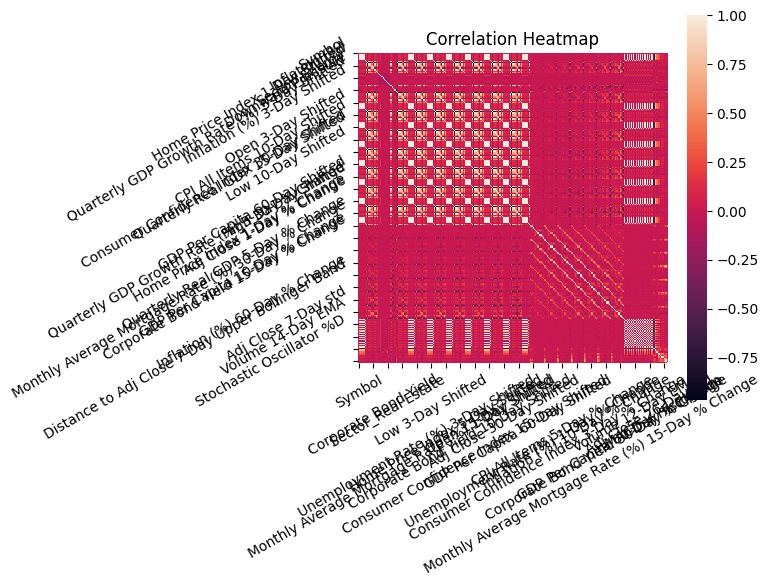

In [8]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [9]:
# Get columns of correlation matrix that have high correlation to other features (need upper triangular matrix to stop wrong features being dropped)
correlation_threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in list(upper.columns) if any(upper[column] > correlation_threshold)]
print(to_drop)  

['Close', 'High', 'Low', 'Open', 'Consumer Confidence Index', 'CPI All Items', 'GDP Per Capita', 'Quarterly Real GDP', 'Year', 'Unemployment Rate (%) 1-Day Shifted', 'Consumer Confidence Index 1-Day Shifted', 'CPI All Items 1-Day Shifted', 'Inflation (%) 1-Day Shifted', 'Monthly Average Mortgage Rate (%) 1-Day Shifted', 'Corporate Bond Yield 1-Day Shifted', 'GDP Per Capita 1-Day Shifted', 'Quarterly Real GDP 1-Day Shifted', 'Quarterly GDP Growth Rate (%) 1-Day Shifted', 'Home Price Index 1-Day Shifted', 'Adj Close 1-Day Shifted', 'Close 1-Day Shifted', 'High 1-Day Shifted', 'Low 1-Day Shifted', 'Open 1-Day Shifted', 'S&P500 1-Day Shifted', 'Unemployment Rate (%) 3-Day Shifted', 'Consumer Confidence Index 3-Day Shifted', 'CPI All Items 3-Day Shifted', 'Inflation (%) 3-Day Shifted', 'Monthly Average Mortgage Rate (%) 3-Day Shifted', 'Corporate Bond Yield 3-Day Shifted', 'GDP Per Capita 3-Day Shifted', 'Quarterly Real GDP 3-Day Shifted', 'Quarterly GDP Growth Rate (%) 3-Day Shifted', 'Hom

In [10]:
# Drop highly correlated features from X_train and X_test
X_train_normalized.drop(to_drop, axis=1, inplace=True)
X_test_normalized.drop(to_drop, axis=1, inplace=True)

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

X_train_normalized: (635129, 125)
X_test_normalized: (153972, 125)


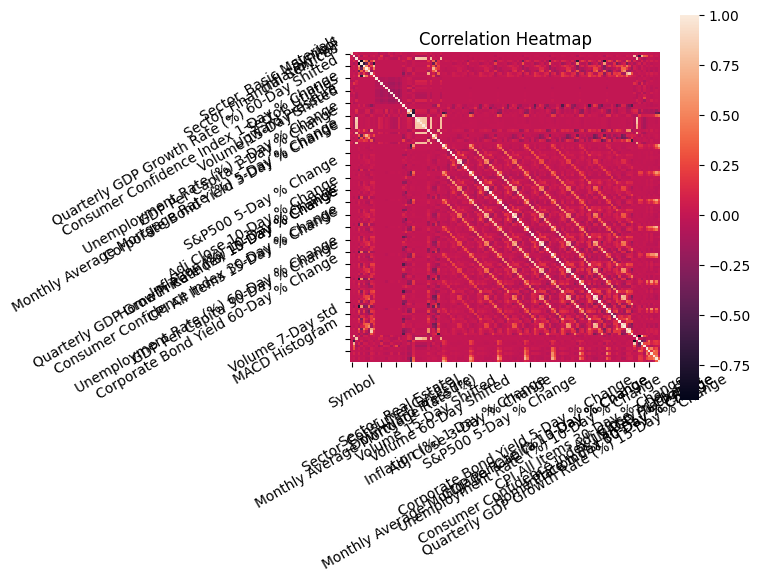

In [11]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

## Wrapper Methods

Wrapper methods eliminate features by looking at weights/coefficients of features in a trained model. In this case we use CatBoost's built-in method select_features(). This selects a subset of features based on their SHAP (SHapely Additive exPlanations) values, which measure their contribution to the final outcome.

In [12]:
# Get training and eval set to use while selecting features
from sklearn.model_selection import train_test_split
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_train_normalized, 
    y_train, 
    test_size=0.20, 
    shuffle=False
)

# Print shapes
print(f"X_train_cb: {X_train_cb.shape}")
print(f"y_train_cb: {y_train_cb.shape}")
print(f"X_val_cb: {X_val_cb.shape}")
print(f"y_val_cb: {y_val_cb.shape}")

X_train_cb: (508103, 125)
y_train_cb: (508103,)
X_val_cb: (127026, 125)
y_val_cb: (127026,)


In [13]:
# Get training and validation pools
from catboost import Pool
feature_names = list(X_train_cb.columns)
train_pool = Pool(X_train_cb, y_train_cb, feature_names=feature_names)
val_pool = Pool(X_val_cb, y_val_cb, feature_names=feature_names)

# Build CatBoost model
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=25000,
    learning_rate=0.01,
    early_stopping_rounds=250,
    loss_function='Logloss'
)

In [14]:
# Select best features
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
summary = model.select_features(
    X=train_pool,
    eval_set=val_pool,
    features_for_select=f'0-{len(feature_names) - 1}',
    num_features_to_select=int(0.5*len(feature_names)),
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Verbose",
    plot=True
)
print(summary)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 10
0:	learn: 0.6925075	test: 0.6929063	best: 0.6929063 (0)	total: 274ms	remaining: 1h 54m 15s
1:	learn: 0.6917837	test: 0.6927783	best: 0.6927783 (1)	total: 469ms	remaining: 1h 37m 47s
2:	learn: 0.6911741	test: 0.6926493	best: 0.6926493 (2)	total: 663ms	remaining: 1h 32m 7s
3:	learn: 0.6904582	test: 0.6924612	best: 0.6924612 (3)	total: 846ms	remaining: 1h 28m 4s
4:	learn: 0.6899012	test: 0.6922403	best: 0.6922403 (4)	total: 1.03s	remaining: 1h 26m 9s
5:	learn: 0.6893115	test: 0.6922174	best: 0.6922174 (5)	total: 1.2s	remaining: 1h 23m 27s
6:	learn: 0.6887389	test: 0.6921295	best: 0.6921295 (6)	total: 1.39s	remaining: 1h 22m 39s
7:	learn: 0.6881110	test: 0.6919457	best: 0.6919457 (7)	total: 1.58s	remaining: 1h 22m 17s
8:	learn: 0.6874481	test: 0.6917766	best: 0.6917766 (8)	total: 1.81s	remaining: 1h 24m 1s
9:	learn: 0.6868571	test: 0.6916112	best: 0.6916112 (9)	total: 1.99s	remaining: 1h 22m 53s
10:	learn: 0.6862824	test: 0.6916026	best: 0.6916026 (10)	total: 2.18s	remain

{'selected_features': [0, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 23, 25, 26, 27, 28, 29, 30, 32, 35, 36, 37, 39, 42, 45, 46, 50, 55, 56, 57, 64, 68, 73, 74, 77, 78, 79, 85, 87, 89, 90, 92, 93, 95, 96, 97, 99, 103, 105, 107, 109, 112, 114, 115, 116, 118, 121, 124], 'eliminated_features_names': ['S&P500', 'S&P500 15-Day % Change', 'Inflation (%) 60-Day % Change', 'S&P500 10-Day % Change', 'Inflation (%)', 'Corporate Bond Yield 60-Day Shifted', 'Quarterly GDP Growth Rate (%) 30-Day Shifted', 'S&P500 5-Day % Change', 'S&P500 60-Day % Change', 'Home Price Index 15-Day % Change', 'S&P500 3-Day % Change', 'Corporate Bond Yield 5-Day % Change', 'Monthly Average Mortgage Rate (%) 5-Day % Change', 'Month', 'Consumer Confidence Index 5-Day % Change', 'CPI All Items 5-Day % Change', 'Monthly Average Mortgage Rate (%) 60-Day Shifted', 'S&P500 1-Day % Change', 'Home Price Index 30-Day % Change', 'Consumer Confidence Index 15-Day % Change', 'Quarterly GDP Growth Rate (%) 60-Day % Change',

In [15]:
# Drop unwanted features from dataframes
X_train_normalized = X_train_normalized[summary['selected_features_names']]
X_test_normalized = X_test_normalized[summary['selected_features_names']]

## Write outputs

In [16]:
# Training set, test set and selected features
X_train_normalized.to_csv(path_or_buf="X_train_normalized.csv")
X_test_normalized.to_csv(path_or_buf="X_test_normalized.csv")
y_train.to_csv(path_or_buf="y_train.csv")
y_test.to_csv(path_or_buf="y_test.csv")